In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directorpredict_sdf into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
import torch
from torch import nn
from siren_pytorch.siren_pytorch import Modulator, SirenNet
from utils.helpers import cartesian_to_spherical, spherical_to_cartesian
from models import Siren_PINN
#net = MLP_PINN(N_layers=8, width=32, loss_lambda=[1.0, 1.0], activation=nn.ELU()).to(device)
net = Siren_PINN(dim_in=3, dim_out=1, num_layers=3, dim_hidden=256).to(device)

In [4]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset, batch_loader

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
#train_dataset.points.requires_grad_(True)

#train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', device=device)
print(train_dataset)

ImplicitDataset (19683 points)


In [5]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=0.5, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-6,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [6]:
import math
from utils.helpers import gradient

def adjust_bc(net, bc_x, bc_sdfs, num_sumples=None, sampling_factor=1.0, variance=0.1, q=0.01):
    assert(hasattr(bc_x, 'shape'))
    assert(len(bc_x.shape) == 2)
    
    if num_sumples is None:
        num_sumples = math.floor(sampling_factor * bc_x.shape[0])
    
    idx = torch.multinomial(torch.ones((bc_x.shape[0]), device=bc_x.device), num_sumples, replacement=True)
    extra_points = (bc_x[idx] + torch.randn_like(bc_x[idx], device=idx.device) * variance)
    
    extra_points.requires_grad_(True)
    y = net(extra_points)

    grad = gradient(y, extra_points)
    
    with torch.no_grad():
        residual = (torch.linalg.norm(grad, dim=1) - 1)**2
        min_grad = torch.quantile(residual, q)
        _mark = residual < min_grad

        print(f'Adding {y[_mark].shape[0]} points')
        bc_x = torch.cat((bc_x, extra_points[_mark]))
        bc_sdfs = torch.cat((bc_sdfs, y[_mark]))
    return bc_x, bc_sdfs

def adjust_bc_with_residual(net, bc_x, bc_sdfs, num_sumples=None, sampling_factor=1.0, variance=0.1, q=0.01):
    assert(hasattr(bc_x, 'shape'))
    assert(len(bc_x.shape) == 2)
    
    if num_sumples is None:
        num_sumples = math.floor(sampling_factor * bc_x.shape[0])
    
    idx = torch.multinomial(torch.ones((bc_x.shape[0]), device=bc_x.device), num_sumples, replacement=True)
    extra_points = (bc_x[idx] + torch.randn_like(bc_x[idx], device=idx.device) * variance)
    
    extra_points.requires_grad_(True)
    y = net(extra_points)

    grad = gradient(y, extra_points)
    
    with torch.no_grad():
        residual = (torch.linalg.norm(grad, dim=1) - 1)**2
        min_grad = torch.quantile(residual, q)
        _mark = residual < min_grad

        print(f'Adding {y[_mark].shape[0]} points')
        bc_x = torch.cat((bc_x, extra_points[_mark]))
        bc_sdfs = torch.cat((bc_sdfs, y[_mark]))
    return bc_x, bc_sdfs

In [6]:
max_epochs = 2500
PRINT_EVERY_EPOCH = 100

use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points
sdfs = train_dataset.sdfs
points.requires_grad_(True)
try:
    # Training
    epoch = 0
    while epoch < max_epochs:
        #for residual_points in batch_loader(train_dataset.points, num_batches=10):
            #residual_points.requires_grad_(True)
            #if train_dataset.points.grad is not None:
                #train_dataset.points.grad.zero_()
            optimizer.zero_grad()
            y = net(points)
            #loss = net.loss(y, residual_x=residual_points, bc_x=train_dataset.bc_points, bc_sdf=train_dataset.bc_sdfs)
            #y = net(train_dataset.points)
            loss = net.loss(y, points, points, sdfs)
            loss.backward()
        
            lr_scheduler.optimizer.step(lambda: loss)
            lr_scheduler.step_when((epoch % 500) == 499)
            lr_scheduler.step_loss(loss)

            if epoch % PRINT_EVERY_EPOCH == 0:
                print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}')
            epoch += 1
        
            # if device.type == 'cuda':
            #     torch.cuda.empty_cache()
        
        # if epoch % 100:
        #     net.loss_lambda[0] = epoch / 2000.0
        
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 100.935295, 0.730699
#100 Loss: 0.078254, 0.005640
#200 Loss: 0.055386, 0.005149
#300 Loss: 0.044756, 0.004853
#400 Loss: 0.038191, 0.004592
#500 Loss: 0.033668, 0.004388
#600 Loss: 0.032899, 0.004355
#700 Loss: 0.032106, 0.004321
#800 Loss: 0.031300, 0.004286
#900 Loss: 0.030486, 0.004252
#1000 Loss: 0.029673, 0.004218
#1100 Loss: 0.029506, 0.004211
#1200 Loss: 0.029330, 0.004204
#1300 Loss: 0.029144, 0.004196
#1400 Loss: 0.028950, 0.004188
#1500 Loss: 0.028746, 0.004180
#1600 Loss: 0.020182, 0.003796
#1700 Loss: 0.015464, 0.003653
#1800 Loss: 0.012430, 0.003540
#1900 Loss: 0.010246, 0.003453
#2000 Loss: 0.008605, 0.003391
#2100 Loss: 0.007781, 0.003353
#2200 Loss: 0.007084, 0.003312
#2300 Loss: 0.006469, 0.003280
#2400 Loss: 0.005926, 0.003244


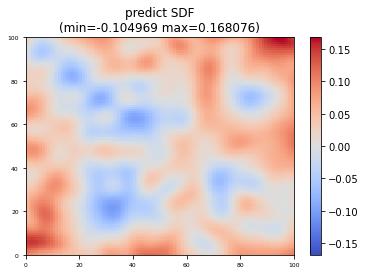

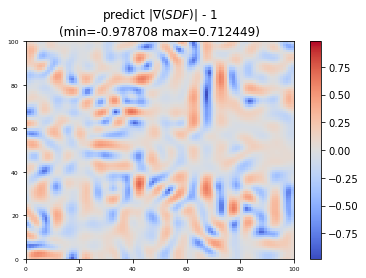

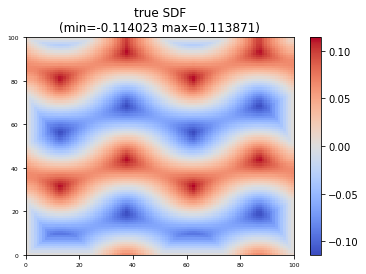

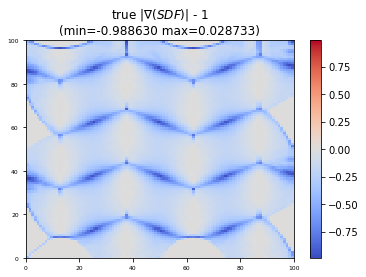

In [7]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0.0, step=0.05, offset=30, nums=100, device=device)
#visualize.from_nn(net, bounds_from_mesh=output_stl, device=device)
#visualize.from_mesh(output_stl)
visualize.from_dataset(net, dataset_name + '_slice.npz')